l'objectif de cette partie est d'extraire les zones à risques d'innodation à partir du fichier shapefile Georisques 


/tmp/ipykernel_136750/702847710.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (gdf.geometry.centroid.y >= 41) & (gdf.geometry.centroid.y <= 51) &  # Filtrer par latitude
/tmp/ipykernel_136750/702847710.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (gdf.geometry.centroid.x >= -5) & (gdf.geometry.centroid.x <= 10)   # Filtrer par longitude


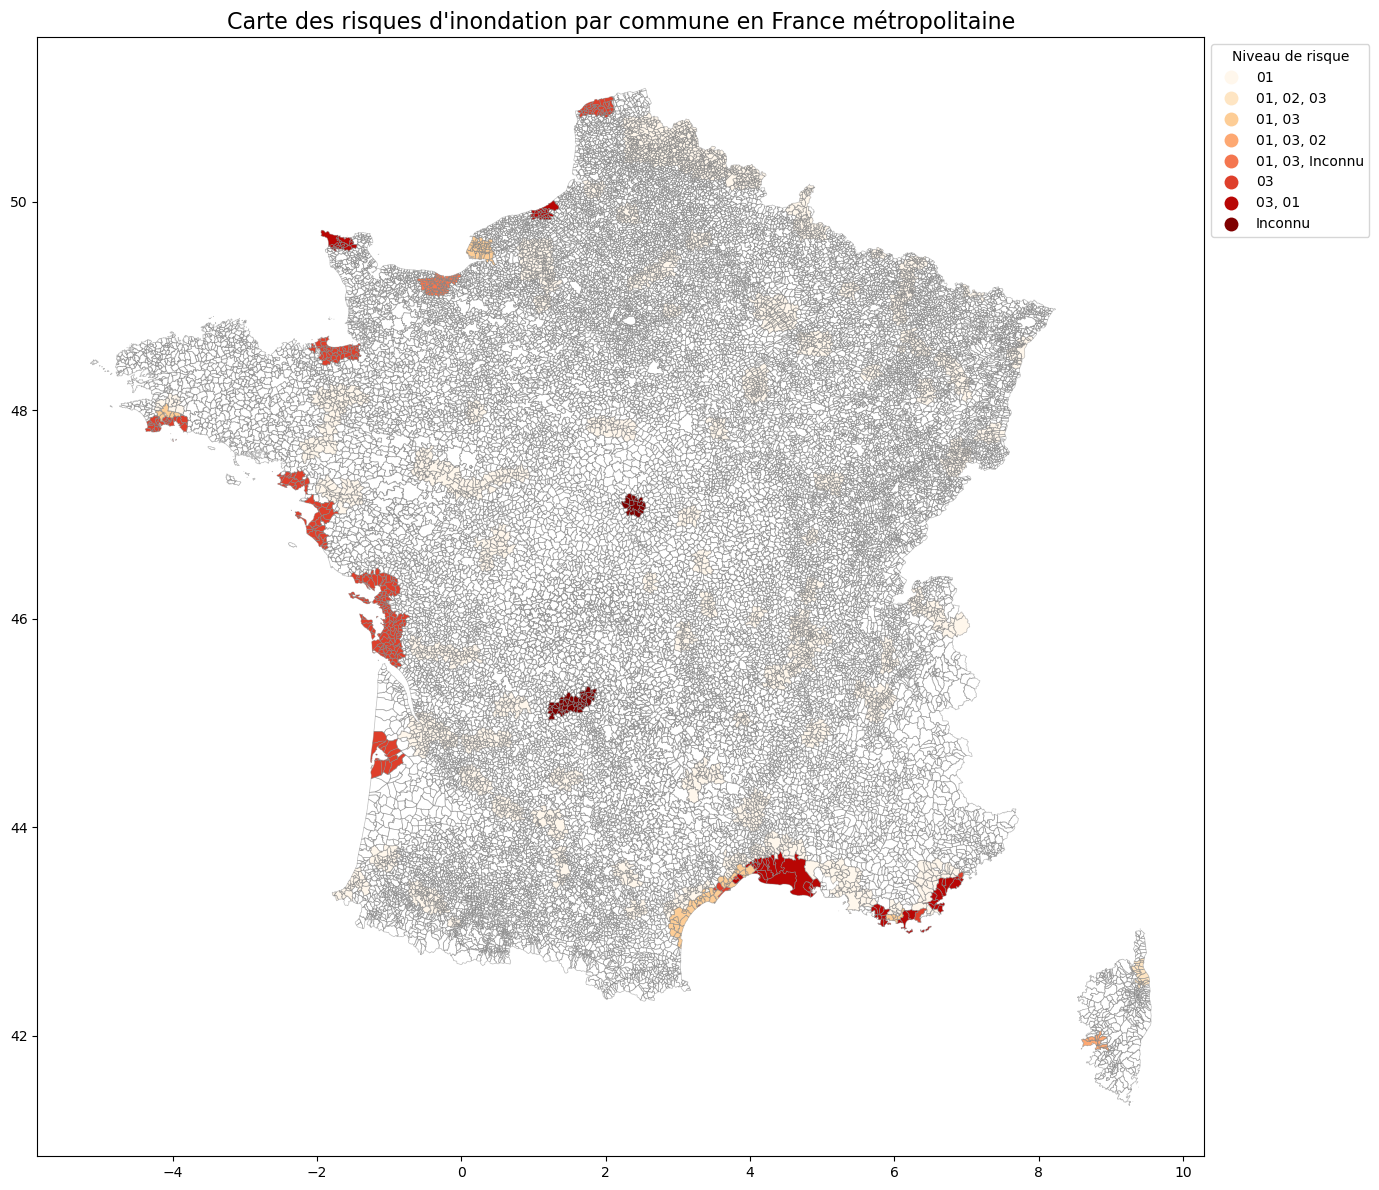

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download

# Charger les données géographiques du Shapefile
shapefile_path = "n_carte_inond_s.shp"
gdf = gpd.read_file(shapefile_path)

gdf = gdf[
    (gdf.geometry.centroid.y >= 41) & (gdf.geometry.centroid.y <= 51) &  # Filtrer par latitude
    (gdf.geometry.centroid.x >= -5) & (gdf.geometry.centroid.x <= 10)   # Filtrer par longitude
]
# Télécharger le fond de carte via Cartiflette
france = carti_download(
    values=["France"],
    crs=4326,
    borders="COMMUNE",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# Filtrer les communes métropolitaines pour le fond de carte
france = france.loc[france["INSEE_REG"] > 10]

# Vérifier et aligner les CRS
if gdf.crs != france.crs:
    gdf = gdf.to_crs(france.crs)

# Effectuer une jointure spatiale entre les points du Shapefile et les communes
joined = gpd.sjoin(gdf, france, how="left", predicate="intersects")

# Remplacer les valeurs nulles dans 'typ_inond1' par une valeur par défaut
joined["typ_inond1"] = joined["typ_inond1"].fillna("Inconnu")

# Agréger les risques pour chaque commune
commune_risks = joined.groupby("INSEE_COM")["typ_inond1"].apply(lambda x: ', '.join(x.unique())).reset_index()

# Ajouter les risques au fond de carte
france = france.merge(commune_risks, on="INSEE_COM", how="left")

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Ajouter les limites des communes
france.boundary.plot(ax=ax, linewidth=0.5, color="gray", alpha=0.5)

# Remplir les communes avec les risques associés
france.plot(
    column="typ_inond1",
    ax=ax,
    legend=True,
    cmap="OrRd",
    legend_kwds={
        "title": "Niveau de risque",
        "loc": "upper left",
        "bbox_to_anchor": (1, 1),
    },
)

# Ajouter un titre
ax.set_title("Carte des risques d'inondation par commune en France métropolitaine", fontsize=16)

plt.tight_layout()
plt.show()
